<a href="https://colab.research.google.com/github/MattLeRoi/new_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Marketing Campaign Analysis

## Business Understanding
A Portuguese banking institution recorded data about the potential customers targeted for a phone marketing outreach campaign. This involved one or a series of calls. A more detailed understanding of the results of these campaigns could show which customers are more likely to sign, or show which details about the interactions are most likely to lead to customers signing.

## Data Understanding
The bank provided data on ~45,000 customers, including background information on the client (such as age, job, marital status, etc.) and details about their interactions (such as how frequently and how long ago they were contacted). About 12% of the customers signed. Note that the available data is from Portuguese customers and cultural differences to the US or other countries may mean that the learnings here may not transfer perfectly. Also, a few columns like previous outcome and contact type have a high number of unknown entries, but still contribute significantly to the model. Finally, the model identifies correlations, which do not necessarily imply a causal relationship.

### Definition of columns
1 - age (numeric)  
2 - job : type of job (categorical)  
3 - marital : marital status (categorical)  
4 - education (categorical)  
5 - default: has credit in default? (binary)  
6 - balance: average yearly balance, in euros (numeric)  
7 - housing: has housing loan? (binary)  
8 - loan: has personal loan? (binary)  
9 - contact: contact communication type (categorical)  
10 - day: last contact day of the month (numeric)  
11 - month: last contact month of year (categorical)  
12 - duration: last contact duration, in seconds (numeric)  
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
14 - pdays: number of days since the client was last contacted from a previous campaign (numeric, -1 means 
client was not previously contacted)  
15 - previous: number of contacts performed before this campaign and for this client (numeric)  
16 - poutcome: outcome of the previous marketing campaign (categorical)  
17 - y - has the client subscribed a term deposit? (binary)  

In [1]:
# %pip install pandas numpy scikit-learn matplotlib lightgbm catboost imbalanced-learn xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from itertools import product
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

<!-- Download, read, and display the csv file. -->

In [43]:
df=pd.read_csv('./data/bank-full.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Display histograms and counts of people per category

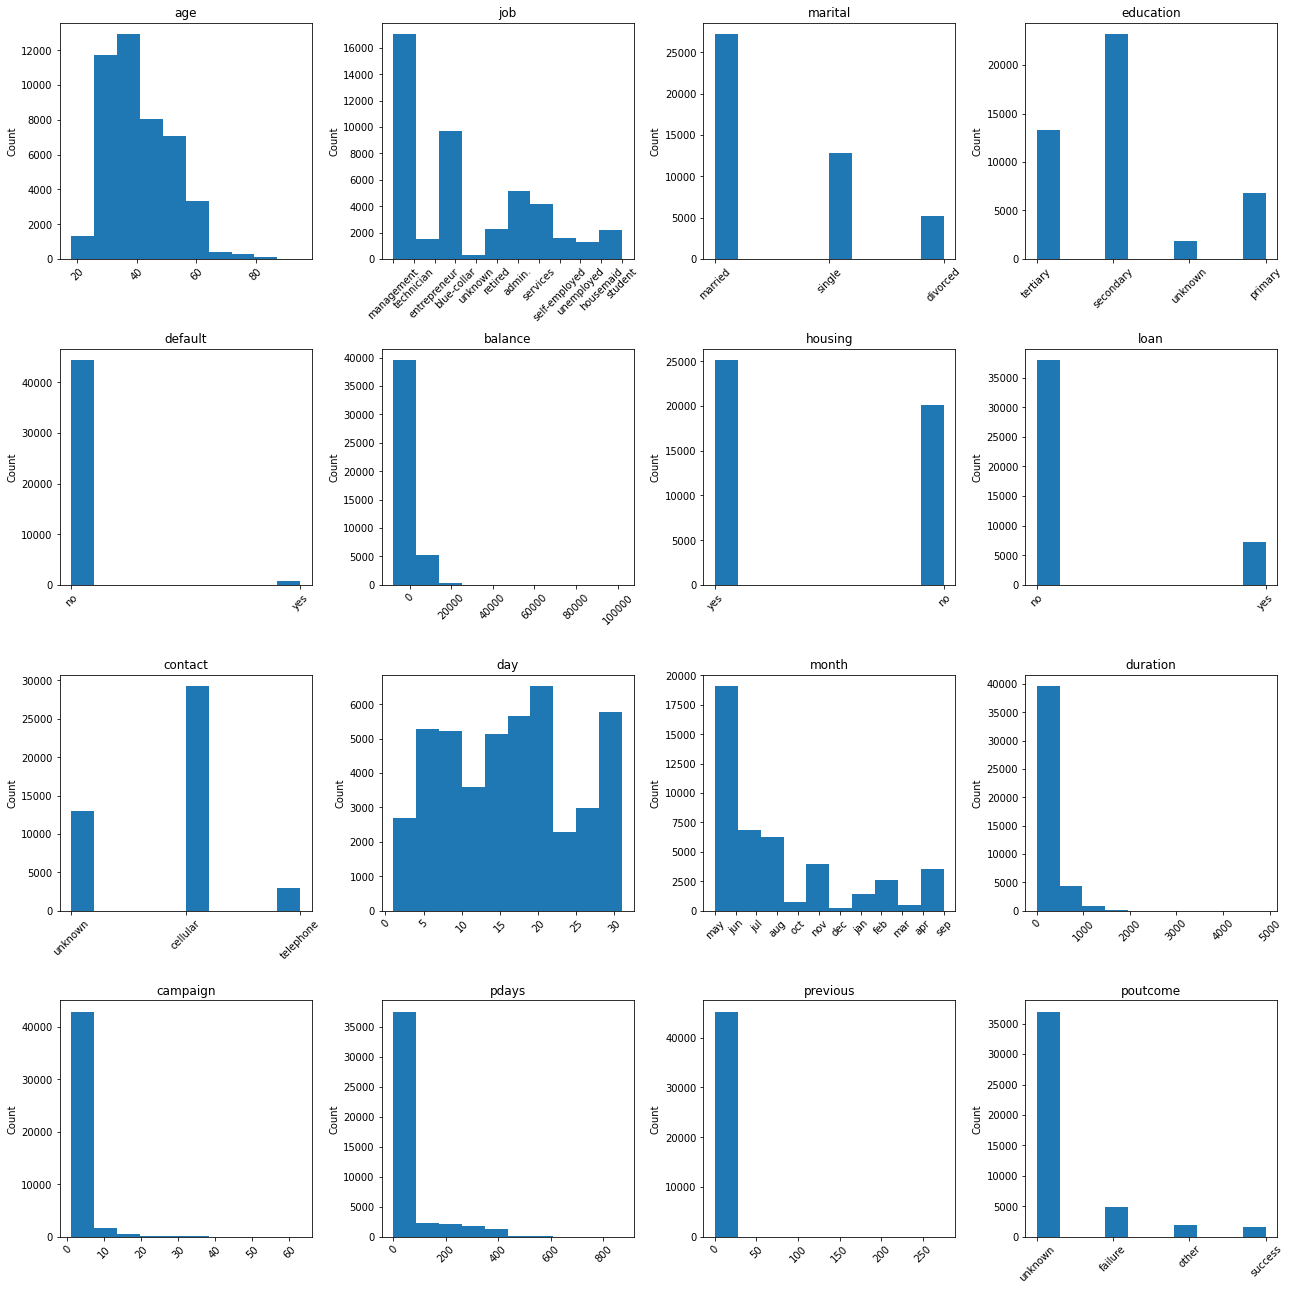

In [4]:
i=1
fig, axes = plt.subplots(4,4, figsize=(18,18))
for col in df.drop('y', axis=1).columns:
    plt.subplot(4,4,i)
    plt.title(col)
    plt.hist(df[col])
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.tight_layout(pad=1.0);
    i+=1

Calculate the percentage of people that signed

In [5]:
y_n_counts = df.y.value_counts()
print("Overall percent signed:",round(y_n_counts[1]/sum(y_n_counts)*100,2),'%')

Overall percent signed: 11.7 %


Create bar charts with % signed for each column and a reference line for the overall signing rate

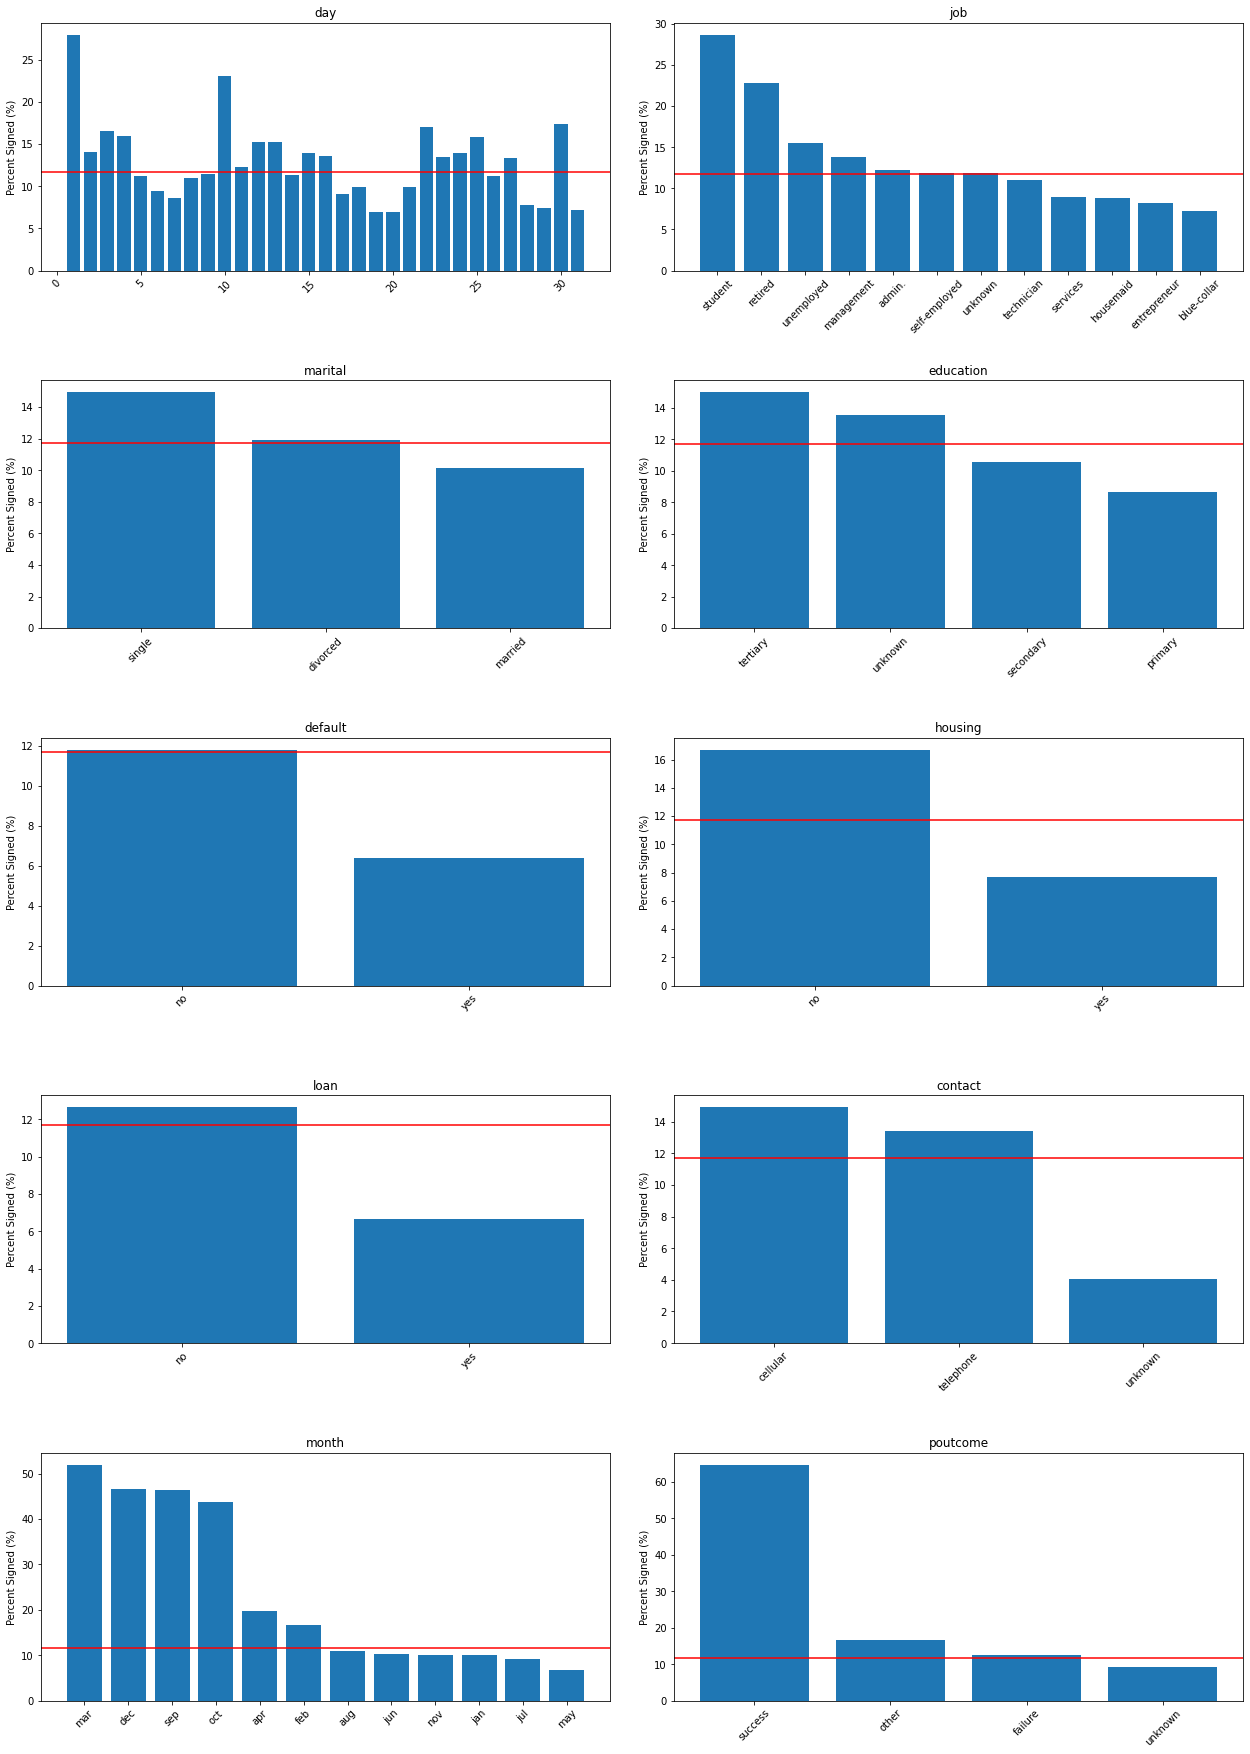

In [6]:
categorical_features = ['day','job','marital','education','default','housing','loan','contact','month','poutcome']
temp_y = []
i=1
fig, axes = plt.subplots(5,2, figsize=(18,25))
for cat in categorical_features:
    temp_y = df.groupby(cat)['y'].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)
    temp_x = temp_y.index
    plt.subplot(5,2,i)
    plt.bar(temp_x, temp_y)
    plt.title(cat)
    plt.xticks(rotation=45)
    plt.ylabel('Percent Signed (%)')
    plt.axhline(y=11.7, color='r')
    plt.tight_layout(pad=3.0);
    i+=1

## Data Preparation

Separate the X and y.

In [7]:
# The -1 in pdays is a code, not a number, and makes interpretation of the column messy. Since the "previous" column also acts
# as a flag for whether the customer was contacted, the pdays column will simply be dropped.
X = df.drop(['y','pdays'], axis=1) 
y = [1 if target_y_n == "yes" else 0 for target_y_n in df['y']]

Encode the categorical features.

In [8]:
X_encoded = pd.get_dummies(X, columns=categorical_features)

Create the test (15%), validation (10%), and training (75%) sets.

In [9]:
# Split both encoded and raw (non-encoded) data
# For models that need encoding: LogisticRegression, RandomForest, LightGBM, and XGBoost
X_all_training_encoded,X_test_encoded,y_all_training_encoded,y_test_encoded = train_test_split(X_encoded,y,random_state=42, test_size=.15)
X_train_encoded,X_val_encoded,y_train_encoded,y_val_encoded = train_test_split(X_all_training_encoded,y_all_training_encoded,random_state=42, test_size=.1/.85)

# For models that can handle categoricals natively: CatBoost
X_all_training_raw,X_test_raw,y_all_training_raw,y_test_raw = train_test_split(X,y,random_state=42, test_size=.15)
X_train_raw,X_val_raw,y_train_raw,y_val_raw = train_test_split(X_all_training_raw,y_all_training_raw,random_state=42, test_size=.1/.85)

Scale each column - fit on the training set, then transform val and test sets.

In [10]:
# Scale only the encoded data (for models that need encoding)
scaler = StandardScaler()
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_encoded.columns)
X_val_encoded = pd.DataFrame(scaler.transform(X_val_encoded), columns=X_encoded.columns)
X_test_encoded = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_encoded.columns)

This will loop through a range of ratios to feed into the SMOTE function to analyze the effect of oversampling the 
churning customers to improve the sensitivity of the model. The results are plotted to visualize the optimum value.

In [42]:
%%time
ratios = np.arange(.2,1,.05)
ROC_AUC_smote = []

for ratio in ratios:
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded) 

    logreg_resample = LogisticRegression(random_state=42)
    logreg_resample.fit(X_train_resampled, y_train_resampled)
    y_proba = logreg_resample.predict_proba(X_val_encoded)[:, 1]
    score = roc_auc_score(y_val_encoded, y_proba)
    ROC_AUC_smote.append(score)

fig, ax = plt.subplots()
ax.plot(ratios,ROC_AUC_smote,label='ROC_AUC score')
ax.set_ylabel('ROC_AUC score')
ax.set_xlabel('SMOTE ratio')
plt.show();

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

Apply the optimal ratio for SMOTE

In [12]:
smote = SMOTE(sampling_strategy=0.35, random_state=42)
X_train_encoded, y_train_encoded = smote.fit_resample(X_train_encoded, y_train_encoded) 

## Modeling

Create a function that takes in a fitted model, calculates the ROC_AUC score for the validation set, and adds the result to the list of results.

In [13]:
roc_results = pd.DataFrame(columns=['Model','Score'])
imp_factors = pd.DataFrame()
def add_score (roc_results,model_name,model_title, X_val_data, y_val_data):
    y_proba = model_name.predict_proba(X_val_data)[:, 1]
    score = roc_auc_score(y_val_data, y_proba)
    print("ROC-AUC:", score,'\n')
    new_row_data = {'Model':model_title, 'Score':score}
    roc_results.loc[len(roc_results)] = new_row_data
    return roc_results

### Baseline models

Initialize and fit 5 different models to see which is the most promising for further tuning.

In [14]:
log_reg = LogisticRegression(random_state=42)
rf=RandomForestClassifier(random_state=42)
xgb_model=XGBClassifier(random_state=42)
lgbm_model=LGBMClassifier(random_state=42,verbose=0)
cat_boost=CatBoostClassifier(random_state=42,verbose=0)

# Train models that need encoding
models_encoded = [('log_reg', log_reg),('rf', rf),('xgb_model', xgb_model), ('lgbm_model', lgbm_model)]
for title, model in models_encoded:
    print(title)
    model.fit(X_train_encoded, y_train_encoded)
    add_score(roc_results, model, title, X_val_encoded, y_val_encoded)

# For CatBoost, specify categorical features
cat_boost.fit(X_train_raw, y_train_raw, cat_features=categorical_features, verbose=False)
print('cat_boost')
add_score(roc_results, cat_boost, 'cat_boost', X_val_raw, y_val_raw)

log_reg
ROC-AUC: 0.9136006261549144 

rf
ROC-AUC: 0.9264493563865055 

xgb_model
ROC-AUC: 0.9305790952139951 

lgbm_model
ROC-AUC: 0.9330860688378078 

cat_boost
ROC-AUC: 0.9395349544311445 



,Model,Score
0,log_reg,0.913601
1,rf,0.926449
2,xgb_model,0.930579
3,lgbm_model,0.933086
4,cat_boost,0.939535


### Identify most important factors from each model and show the top five.

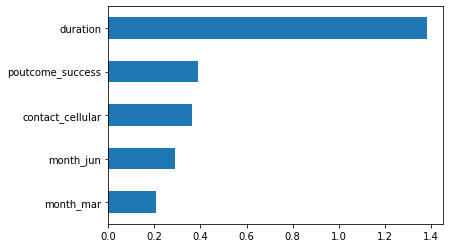

In [15]:
# Logistic Regression
coefs = pd.Series(log_reg.coef_[0], index=X_train_encoded.columns).sort_values(ascending=False).head(5).sort_values(ascending=True)
coefs.plot(kind='barh');
imp_factors['LogisticRegression']=coefs.sort_values(ascending=False).head(5).index

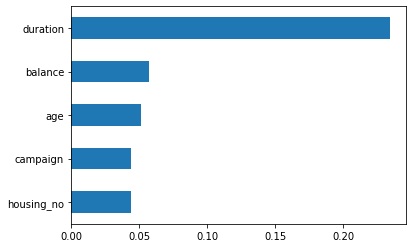

In [16]:
# Random Forest
importances = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)
importances.sort_values(ascending=False).head(5).sort_values(ascending=True).plot(kind='barh');
imp_factors['RandomForestClassifier']=importances.sort_values(ascending=False).head(5).index

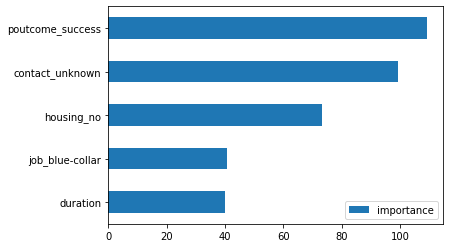

In [17]:
# XGBoost
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({'importance':list(importance.values())}, index=importance.keys())

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['XGBClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

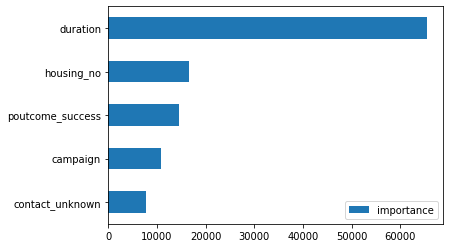

In [18]:
# Light GBM
importance = lgbm_model.booster_.feature_importance(importance_type='gain')
feature_names = lgbm_model.feature_name_

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['LGBMClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

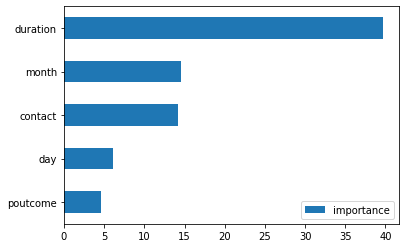

In [19]:
# Cat Boost
importance = cat_boost.get_feature_importance()
feature_names = X_train_raw.columns

importance_df = pd.DataFrame({'importance':importance}, index=feature_names)

importances=importance_df.sort_values(by='importance', ascending=True).tail(5)
importances.plot(kind='barh');
imp_factors['CatBoostClassifier']=importances.sort_values(by='importance',ascending=False).head(5).index

These are the top five factors for each model. I created a composite score to find out, across all of the models, which factors showed up as consistently important (for each model, 1st place is 5 points, 2nd place is 4 points, etc.). 

In [20]:
factor_importance_results = pd.DataFrame(columns=['score'], index=X_train_encoded.columns)

for cat in X_train_encoded.columns:
    tot_factor_weight=0
    for col in imp_factors:
        ind_factor_weight = 5-imp_factors[imp_factors[col].str.contains(cat, case=False, na=False)].index
        if ind_factor_weight > 0:
            tot_factor_weight += ind_factor_weight
    if tot_factor_weight > 0:
        factor_importance_results.at[cat, 'score'] = tot_factor_weight[0]
    else: factor_importance_results.at[cat, 'score'] = 0
display(imp_factors)
factor_importance_results.sort_values(by='score', ascending=False).head(5)

,LogisticRegression,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,duration,duration,poutcome_success,duration,duration
1,poutcome_success,balance,contact_unknown,housing_no,month
2,contact_cellular,age,housing_no,poutcome_success,contact
3,month_jun,campaign,job_blue-collar,campaign,day
4,month_mar,housing_no,duration,contact_unknown,poutcome


,score
duration,21
poutcome_success,12
housing_no,8
contact_unknown,5
campaign,4


### Tuning

For the CatBoostClassifier, several parameters (learning_rates, depths, l2_leaf_regs, and class_weights) are varied to see which yields the highest ROC_AUC score on the validation set.

In [58]:
# This is the best result from previous runs. To save run time it is manually entered here. To run the full parameter set, which
# takes ~20 minutes, uncomment the next cell and it will overwrite this result.
results_df = pd.DataFrame([(8, 0.07, 1, 3, 0.940960)], columns=['depth', 'learning_rate', 'l2_leaf_reg', 'class_weights', 'AUC'])

In [27]:
%%time

# # Uncomment this section to run the full parameter set (takes ~20 minutes)
# depths = [6,8,10]
# learning_rates = [0.03, .05, .07]
# l2_leaf_regs = [1,3]
# class_weights = [1,3]
# total_runs = product(learning_rates, depths, l2_leaf_regs, class_weights)
# num_runs = len(depths)*len(learning_rates)*len(l2_leaf_regs)*len(class_weights)

# train_pool = Pool(X_train_raw, y_train_raw, cat_features=categorical_features)
# val_pool = Pool(X_val_raw, y_val_raw, cat_features=categorical_features)

# results = []

# i=1
# for lr, d, l2, cw in total_runs:
#     model = CatBoostClassifier(
#         learning_rate=lr,
#         depth=d,
#         l2_leaf_reg=l2,
#         iterations=1000,
#         early_stopping_rounds=50,
#         use_best_model=True,
#         verbose=False,
#         random_seed=42,
#         class_weights=[1,cw]
#     )
#     model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
#     y_proba = model.predict_proba(X_val_raw)[:, 1]
#     score = roc_auc_score(y_val_raw, y_proba)
#     results.append((d, lr, l2, cw, score))
#     print(i,' of ', num_runs)
#     i+=1

# results_df = pd.DataFrame(results, columns=['depth', 'learning_rate', 'l2_leaf_reg', 'class_weights', 'AUC'])
# results_df=results_df.sort_values('AUC', ascending=False)
# display(results_df.head())

1  of  36
2  of  36
3  of  36
4  of  36
5  of  36
6  of  36
7  of  36
8  of  36
9  of  36
10  of  36
11  of  36
12  of  36
13  of  36
14  of  36
15  of  36
16  of  36
17  of  36
18  of  36
19  of  36
20  of  36
21  of  36
22  of  36
23  of  36
24  of  36
25  of  36
26  of  36
27  of  36
28  of  36
29  of  36
30  of  36
31  of  36
32  of  36
33  of  36
34  of  36
35  of  36
36  of  36


,depth,learning_rate,l2_leaf_reg,class_weights,AUC
29,8,0.07,1,3,0.940960
1,6,0.03,1,3,0.940811
19,8,0.05,3,3,0.940757
27,6,0.07,3,3,0.940753
15,6,0.05,3,3,0.940574


Wall time: 21min 55s


## Evaluation

Run the final tuned model with the validation data for comparison to the baseline models.

In [28]:
%%time
best_params = {
    'depth': results_df['depth'].iloc[0],
    'learning_rate': results_df['learning_rate'].iloc[0],
    'iterations': 1000,
    'l2_leaf_reg': results_df['l2_leaf_reg'].iloc[0],
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'use_best_model': True,
    'verbose': False,
    'class_weights': [1, results_df['class_weights'].iloc[0]]
}

final_model = CatBoostClassifier(**best_params);
final_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50);
add_score(roc_results,final_model,'final_model', X_val_raw, y_val_raw)

ROC-AUC: 0.9409703831864067 

Wall time: 24 s


,Model,Score
0,log_reg,0.913601
1,rf,0.926449
2,xgb_model,0.930579
3,lgbm_model,0.933086
4,cat_boost,0.939535
5,final_model,0.940970


Run the final model on the test data.

In [29]:
y_pred = final_model.predict(X_test_raw)
y_proba = final_model.predict_proba(X_test_raw)[:, 1]

print(confusion_matrix(y_test_raw,y_pred))
print(roc_auc_score(y_test_raw,y_proba))


[[5440  530]
 [ 175  637]]
0.936988926570455


# Next steps:

Collect more detailed data - filling in all of the missing data may lead to further insights.
Run a controlled experiment - design an experiment to determine whether call duration and number of contacts are causal or correlative relationships.
The data varied by month, both in volume and in the success rate. This may indicate seasonality or it may have been due to the timing of the marketing campaign, which I don not have access to. It is worth further investigation